In [1]:
using  GridapGmsh
using  Gridap
using  Gridap.Geometry
using  Gridap.TensorValues
using  Plots
using LinearAlgebra
using LineSearches: BackTracking
using Gridap.Arrays
using Gridap.ReferenceFEs

In [2]:
const  E_mat = 210e3
const  ν_mat = 0.3
const  Gc = 2.7
const  ls = 0.015
const  η = 1e-15

1.0e-15

In [3]:
path = "./fatigueresults$ls/"                                # Output path
mkpath(path) 

"./fatigueresults0.015"

In [4]:
cd("fatigueresults$ls")

In [5]:
using  Gmsh: gmsh
const  L = 1.0
const  H = 1.0
const  CH = H/50 #Crack  height
const  hfc = 0.005/100 #Mesh  size  parameter
const  hf = 0.005/6 #Mesh  size  parameter
const  h = 25*hf #Mesh  size  parameter
const  FMR = 4*0.010
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.geo.addPoint(0.0, 0.0 , 0.0, h ,1)
gmsh.model.geo.addPoint(L, 0.0, 0.0, h, 2)
gmsh.model.geo.addPoint(L, H/2, 0.0, h, 22)
gmsh.model.geo.addPoint(L, H, 0.0, h, 3)
gmsh.model.geo.addPoint(0.0, H, 0.0, h, 4)
gmsh.model.geo.addPoint(0.0, 0.5*H + 0.5*CH, 0.0, h, 5)
gmsh.model.geo.addPoint(0.5*L-CH, 0.5*H + 0.5*CH, 0.0, h, 6)
gmsh.model.geo.addPoint(0.5*L, 0.5*H, 0.0, h, 7)
gmsh.model.geo.addPoint(0.5*L-CH, 0.5*H - 0.5*CH , 0.0, h ,8)
gmsh.model.geo.addPoint(0.0, 0.5*H - 0.5*CH , 0.0, h, 9)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 22, 11)
gmsh.model.geo.addLine(22, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 7, 6)
gmsh.model.geo.addLine(7, 8, 7)
gmsh.model.geo.addLine(8, 9, 8)
gmsh.model.geo.addLine(9, 1, 9)

gmsh.model.geo.addCurveLoop([1,11,2,3,4,5,6,7,8,9],1)

gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.addPhysicalGroup(2, [1],1)

gmsh.model.addPhysicalGroup(0, [22],1)
gmsh.model.addPhysicalGroup(1, [1],1)
gmsh.model.addPhysicalGroup(1, [3],2)


gmsh.model.setPhysicalName(2, 1, "Domain")

gmsh.model.setPhysicalName(0, 1, "DirichletSidePoint")
gmsh.model.setPhysicalName(1, 1, "DirichletBottom")
gmsh.model.setPhysicalName(1, 2, "DirichletTop")

gmsh.model.mesh.field.add("Box", 10)
gmsh.model.mesh.field.setNumber(10, "VIn", hf)
gmsh.model.mesh.field.setNumber(10, "VOut", h)
gmsh.model.mesh.field.setNumber(10, "XMin", (L/2)-2*CH)
gmsh.model.mesh.field.setNumber(10, "XMax", L)
gmsh.model.mesh.field.setNumber(10, "YMin", 0.5*H - FMR)
gmsh.model.mesh.field.setNumber(10, "YMax", 0.5*H + FMR)

gmsh.model.mesh.field.setAsBackgroundMesh(10)
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("SENT_Mesh.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : Done meshing 1D (Wall 0.000625315s, CPU 0.000609s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 3.21513s, CPU 3.16732s)
Info    : 68910 nodes 137828 elements
Info    : Writing 'SENT_Mesh.msh'...
Info    : Done writing 'SENT_Mesh.msh'


In [6]:
model = GmshDiscreteModel("SENT_Mesh.msh")
writevtk(model ,"SENT_Mesh") 

Info    : Reading 'SENT_Mesh.msh'...
Info    : 21 entities
Info    : 68910 nodes
Info    : 137473 elements
Info    : Done reading 'SENT_Mesh.msh'


3-element Vector{Vector{String}}:
 ["SENT_Mesh_0.vtu"]
 ["SENT_Mesh_1.vtu"]
 ["SENT_Mesh_2.vtu"]

In [7]:
const σc = 2445.42 
const m = 3*E_mat*Gc/(4*ls*σc^2)
const ψ_Crit = σc^2 / (2*E_mat)
const kf = 0.5
const αT = ψ_Crit/kf

28.476566554285714

In [8]:
function degDer(ϕ)
    g = (m*ϕ)/(0.25*m^2*ϕ^4 - 0.5*m^2*ϕ^2 + 0.25*m^2 - m*ϕ^4 + m*ϕ^2 + ϕ^4) 
    return g
end

degDer (generic function with 1 method)

In [9]:
function  ElasFourthOrderConstTensor(E,ν,PlanarState)
    # 1 for  Plane  Stress  and 2 Plane  Strain  Condition
    if  PlanarState  == 1
        C1111 =E/(1-ν*ν)
        C1122 = (ν*E)/(1-ν*ν)
        C1112 = 0.0
        C2222 =E/(1-ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    elseif  PlanarState  == 2
        C1111 = (E*(1-ν*ν))/((1+ν)*(1-ν-2*ν*ν))
        C1122 = (ν*E)/(1-ν-2*ν*ν)
        C1112 = 0.0
        C2222 = (E*(1-ν))/(1-ν-2*ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    end
    C_ten = SymFourthOrderTensorValue(C1111 ,C1112 ,C1122 ,C1112 ,C1212 ,C2212 ,C1122 ,C2212 ,C2222)
    return   C_ten
end
     

const  C_mat = ElasFourthOrderConstTensor(E_mat ,ν_mat ,2)
     

SymFourthOrderTensorValue{2, Float64, 9}(282692.3076923077, 0.0, 121153.84615384616, 0.0, 80769.23076923077, 0.0, 121153.84615384616, 0.0, 282692.3076923077)

In [10]:
I2 = SymTensorValue{2,Float64}(1.0 ,0.0 ,1.0)
I4 = I2⊗I2
I4_sym = one(SymFourthOrderTensorValue{2,Float64})
P_vol = (1.0/2)*I4
P_dev = I4_sym  - P_vol
     

SymFourthOrderTensorValue{2, Float64, 9}(0.5, 0.0, -0.5, 0.0, 0.5, 0.0, -0.5, 0.0, 0.5)

In [11]:
function σfun(ε,ε_in,s_in)
    σ_elas = C_mat⊙ε
    gs = (s_in^2) / (s_in^2 + m*(1-s_in)*(0.5+0.5*s_in))
    if tr(ε_in) >= 0
        σ = (gs)*σ_elas
    elseif  tr(ε_in) < 0
        σ = (gs)*P_dev ⊙ σ_elas + P_vol ⊙ σ_elas
    end
    return  σ
end
     

σfun (generic function with 1 method)

In [12]:
function ψPos(ε_in,Fdg)
   σ_elas = C_mat⊙ε_in
    if tr(ε_in) >= 0
        ψPlus = 0.5*(ε_in ⊙ σ_elas)/(Fdg)
    elseif  tr(ε_in) < 0
        ψPlus = 0.5*((P_dev ⊙ σ_elas)⊙(P_dev⊙ε_in))/(Fdg)
    end
    return ψPlus
end

function ψPosOrg(ε_in)
   σ_elas = C_mat⊙ε_in
    if tr(ε_in) >= 0
        ψPlus = 0.5*(ε_in ⊙ σ_elas)
    elseif  tr(ε_in) < 0
        ψPlus = 0.5*((P_dev ⊙ σ_elas)⊙(P_dev⊙ε_in))
    end
    return ψPlus
end

ψPosOrg (generic function with 1 method)

In [13]:
function  new_EnergyState(ψPlusPrev_in,ψhPos_in)
    ψPlus_in = ψhPos_in
    if ψPlus_in  >=ψPlusPrev_in
        ψPlus_out =ψPlus_in
    else
        ψPlus_out=ψPlusPrev_in
    end
    true,ψPlus_out
end
     

new_EnergyState (generic function with 1 method)

In [14]:
function  project(q,model ,dΩ,order)
    reffe = ReferenceFE(lagrangian ,Float64 ,order)
    V = FESpace(model ,reffe ,conformity =:L2)
    a(u,v) =∫(u*v)*dΩ
    b(v) =∫(v*q)*dΩ
    op = AffineFEOperator(a,b,V,V)
    qh = solve(op)
    return  qh
end
     

project (generic function with 1 method)

In [15]:
function FatigueDegrad(αb)
    fdg = @. ifelse(αb >= αT , ((2*αT)/(αb + αT))*((2*αT)/(αb + αT)), 1.0)
    return fdg
end

FatigueDegrad (generic function with 1 method)

In [16]:
function FatiguehistoryVariable(ψhPos_in,αPrev,αbPrev)
    α = ψhPos_in #(s_in ^2 + η)*ψhPos_in
    if α >= αPrev
       αb = αbPrev + abs(α-αPrev)
    else
       αb = αbPrev
    end
return αb
end

FatiguehistoryVariable (generic function with 1 method)

In [17]:
function αNC(s_in,ψhPos_in)
    gs = (s_in^2) / (s_in^2 + m*(1-s_in)*(0.5+0.5*s_in))
    α = gs * ψhPos_in
return α
end

αNC (generic function with 1 method)

In [18]:
order = 1
reffe_PF = ReferenceFE(lagrangian ,Float64,order)
V0_PF = TestFESpace(model ,reffe_PF;conformity =:H1)
U_PF = TrialFESpace(V0_PF)
sh = zero(V0_PF)

SingleFieldFEFunction():
 num_cells: 137376
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 15015411313376168337

# Modified

In [19]:
reffe_Disp = ReferenceFE(lagrangian ,VectorValue{2,Float64},order)
V0_Disp = TestFESpace(model,reffe_Disp;conformity =:H1,
    dirichlet_tags = ["DirichletSidePoint","DirichletBottom","DirichletTop"],
    dirichlet_masks =[(true,false), (false ,true), (false ,true)])

uh = zero(V0_Disp)

SingleFieldFEFunction():
 num_cells: 137376
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 15015411313376168337

In [20]:
degree = 2*order
Ω= Triangulation(model)
dΩ= Measure(Ω,degree)

GenericMeasure()

In [21]:
labels = get_face_labeling(model)
LoadTagId = get_tag_from_name(labels ,"DirichletTop")
Γ_Load = BoundaryTriangulation(model ,tags = LoadTagId)
dΓ_Load = Measure(Γ_Load ,degree)
n_Γ_Load = get_normal_vector(Γ_Load)

GenericCellField():
 num_cells: 48
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 9411193225329128852

In [22]:
nls = NLSolver(
  show_trace=true,
  method=:newton,
  linesearch=BackTracking(), iterations = 10)
solver = FESolver(nls)

NonlinearFESolver()

In [23]:
function crack_tip_tracker(sh,tol)
    damagetracker = Float64[]
    sVec = Float64[]
    coords = get_node_coordinates(Ω)
    
    sVec = get_free_dof_values(sh)
    
    for i in 1:length(sVec)
        if sVec[i] <= tol
            push!(damagetracker,i)
        end
    end
   damagetracker = round.(Int,damagetracker)
    xloc = Float64[]
    yloc = Float64[]
    if damagetracker!= Float64[]
        for i in 1:length(damagetracker)
            push!(xloc,coords[damagetracker[i]][1])
            push!(yloc,coords[damagetracker[i]][2])
        end
        Locx, index= findmax(xloc)
        Locy = yloc[index]
        return (Locx,Locy)
    else 
       return "No damage"
    end
end

crack_tip_tracker (generic function with 1 method)

In [24]:
function stepPhaseField(x0,vApp,cache,ψPlusPrev_in)
     U_PF = TrialFESpace(V0_PF)
     res(s,ϕ) = ∫( (3/4)*Gc*ls*∇(ϕ)⋅ ∇(s) + (degDer∘(s))*ψPlusPrev_in*ϕ - ((3/8)*Gc/ls)*ϕ)*dΩ
     op = FEOperator(res,U_PF,V0_PF)
     sh_out = FEFunction(U_PF,x0)
     sh_out, cache = solve!(sh_out,solver,op,cache)
  return sh_out, get_free_dof_values(sh_out), cache
end

stepPhaseField (generic function with 1 method)

In [25]:
function  stepDisp(uh_in,sh_in ,vApp)
    uApp1(x) = VectorValue(0.0,0.0)
    uApp2(x) = VectorValue(0.0,-vApp)
    uApp3(x) = VectorValue(0.0,vApp)
    U_Disp = TrialFESpace(V0_Disp ,[uApp1 ,uApp2,uApp3])
    a_Disp(u,v) =∫( (ε(v)⊙(σfun∘(ε(u),ε(uh_in),sh_in)) ) )*dΩ
    b_Disp(v) = 0.0
    op_Disp = AffineFEOperator(a_Disp ,b_Disp ,U_Disp ,V0_Disp)
    uh_out = solve(op_Disp)
    return  uh_out
end
     

stepDisp (generic function with 1 method)

In [26]:
vApp = 0
const innerMax = 10
const tol_lim = 1e-10
count = 0

const T = 1
const n = 200
const Tₚ = T/n
const n1 = 16 # loadsteps
const delv = 0.001
const tp = Tₚ/n1
t = 0.0
cycle = 0
const dc = 1/n1

Load = Float64[]
Displacement = Float64[]
time = Float64[]
AppDisplacement = Float64[]
αEnergy = Float64[]
αDegrad = Float64[]
NoofCycles = Float64[]
Xloccrack = Float64[]
Yloccrack = Float64[]
FracEnergy = Float64[]


push!(Xloccrack,(L/2))
push!(Yloccrack,0.5*H)
push!(Load, 0.0)
push!(Displacement, 0.0)

push!(time, t)
push!(AppDisplacement, vApp)
push!(NoofCycles, cycle)

push!(αEnergy, 0.0)
push!(αDegrad, 1.0)
push!(FracEnergy, 0.0)


sPrev = CellState(1.0,dΩ)
sh = project(sPrev ,model ,dΩ,order)
x0_PF = ones(Float64,num_free_dofs(V0_PF))
cache_1 = nothing

αPrev = CellState(0.0,dΩ)
αbPrev = CellState(0.0,dΩ)

αhPlusPrev = project(αPrev,model,dΩ,order)
αbhPlusPrev = project(αbPrev,model,dΩ,order)

FdhPrev = FatigueDegrad∘(αbhPlusPrev)

ψPlusPrev = CellState(ψ_Crit,dΩ)

while  t .< T
    t = t + tp
    vAppC = abs(4*delv/Tₚ * abs((((t-Tₚ/4)%Tₚ)+Tₚ)%Tₚ - Tₚ/2) - delv)
    vApp = round(vAppC,digits = 6)
    count = count .+ 1
    cycle = cycle + dc
    FdhPrev = FatigueDegrad∘(αbhPlusPrev)
    
    print("\n Entering  displacemtent  step$count:", float(vApp))
        
    for  inner = 1: innerMax
        ψhPlusPrev = project(ψPlusPrev ,model ,dΩ,order)
        RelErr = abs(sum(∫( (3/4)*Gc*ls*∇(sh)⋅ ∇(sh) + (degDer∘(sh))*ψhPlusPrev*sh)*dΩ-∫( ((3/8)*Gc/ls)*sh)*dΩ))/abs(sum(∫( ((3/8)*Gc/ls)*sh)*dΩ))
        
        println("\n Relative error =", float(RelErr), "\n")
        sh,x0_PF,cache_1 = stepPhaseField(x0_PF,vApp,cache_1,ψhPlusPrev)
        uh = stepDisp(uh,sh,vApp)
        
        ψhPos_in =ψPos∘(ε(uh),FdhPrev)
        
        update_state!( new_EnergyState ,ψPlusPrev ,ψhPos_in)
        if   RelErr  < 1e-6
            break
        end
    end
    
    if  crack_tip_tracker(sh,tol_lim) =="No damage"
        push!(Xloccrack,0.5*L)
        push!(Yloccrack,0.5*H)
    else
        (X_t, Y_t) = crack_tip_tracker(sh,tol_lim)
        push!(Xloccrack,X_t)
        push!(Yloccrack,Y_t)
    end
    
    ψhPosOrg_in = ψPosOrg∘(ε(uh))
    αPrev = αNC∘(sh,ψhPosOrg_in)
    αbPrev = FatiguehistoryVariable∘(αPrev,αhPlusPrev,αbhPlusPrev)
    
    αhPlusPrev = project(αPrev,model,dΩ,order)
    αbhPlusPrev = project(αbPrev,model,dΩ,order)
    
    FdhPrev = FatigueDegrad∘(αbhPlusPrev)
    
    αbPrevVal = evaluate(αbPrev,VectorValue(0.5*L, 2*CH))
    Fdegrad = evaluate(FdhPrev,VectorValue(0.5*L, 2*CH))
    FracEnergyExp = sum(∫((3/8)*((1-sh)/ls + ls*(∇(sh) ⋅ ∇(sh))))*dΩ)
    
    push!(time, t)
    push!(AppDisplacement, vApp)
    push!(NoofCycles, cycle)
    
    push!(αEnergy, αbPrevVal)
    push!(αDegrad, Fdegrad)
    push!(FracEnergy, FracEnergyExp)
    
    Node_Force = sum(∫(n_Γ_Load⋅(σfun∘(ε(uh),ε(uh),sh)))*dΓ_Load)
    
    push!(Load , Node_Force[2])
    push!( Displacement , vApp)
    if mod(count,n1) == 0
        writevtk(Ω,"results_SENT_Test$count",cellfields= ["uh"=>uh,"s"=>sh , "epsi"=>ε(uh),"Fdeg"=> FdhPrev, "alphabar"=> αbhPlusPrev])
    end
 end     


 Entering  displacemtent  step1:0.00025
 Relative error =2.0715735321311099e-16

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.273710e-18              NaN

 Entering  displacemtent  step2:0.0005
 Relative error =1.8526611659676396e-16

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.273710e-18              NaN

 Entering  displacemtent  step3:0.00075
 Relative error =1.413450402343774e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.074432e-05              NaN
     1     4.914149e-09     1.094198e-04

 Relative error =6.473307379862405e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.010805e-04              NaN
     1     2.033091e-07     2.104136e-03
     2     2.656867e-12     7.207482e-08

 Relative error =3.9869733224420606e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   ----

     2     3.475554e-09     8.221314e-06

 Relative error =1.1550760056171388e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.947769e-04              NaN
     1     3.083277e-06     5.972153e-03
     2     3.370571e-10     8.080107e-07

 Relative error =6.493154024621146e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.679914e-04              NaN
     1     9.929860e-07     1.962193e-03
     2     3.464607e-11     8.365865e-08

 Relative error =3.69466911131196e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.628363e-05              NaN
     1     3.246667e-07     6.493984e-04
     2     3.685065e-12     8.937992e-09

 Relative error =2.1158758296513482e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.537489e-05              NaN
     1     1.070932e-07     2.156602e-04
     2     3.997721e-13    


 Entering  displacemtent  step40:0.0
 Relative error =1.9748793578608404e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.446147e-12              NaN

 Entering  displacemtent  step41:0.00025
 Relative error =1.9748793578608404e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.446147e-12              NaN

 Entering  displacemtent  step42:0.0005
 Relative error =1.9748793578608404e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.446147e-12              NaN

 Entering  displacemtent  step43:0.00075
 Relative error =1.9748793578608404e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.446147e-12              NaN

 Entering  displacemtent  step44:0.001
 Relative error =1.9748793578608404e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.446147e-12     


 Entering  displacemtent  step76:0.001
 Relative error =1.169243017315968e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.377187e-09              NaN

 Entering  displacemtent  step77:0.00075
 Relative error =7.677194917300787e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.688335e-03              NaN
     1     1.589493e-05     4.222848e-01
     2     3.173513e-09     3.241350e-04

 Relative error =1.6047991498012244e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.173513e-09              NaN

 Entering  displacemtent  step78:0.0005
 Relative error =1.6047991498012244e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.173513e-09              NaN

 Entering  displacemtent  step79:0.00025
 Relative error =1.6047991498012244e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -----

     1     1.400194e-05     6.087679e-01
     2     3.340365e-09     6.587393e-04

 Relative error =3.410213650961537e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.170324e-05              NaN
     1     1.138894e-08     2.297358e-05
     2     2.192257e-16     1.667613e-12

 Entering  displacemtent  step110:0.0005
 Relative error =1.5009604873019795e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.397075e-05              NaN
     1     2.742124e-09     4.681074e-06

 Entering  displacemtent  step111:0.00025
 Relative error =2.3487848292995014e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.742124e-09              NaN

 Entering  displacemtent  step112:0.0
 Relative error =2.3487848292995014e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.742124e-09              NaN

 Entering  displacemtent

------   --------------   --------------
     0     1.197163e-04              NaN
     1     1.206179e-08     2.679985e-05
     2     2.041553e-16     1.565686e-12

 Entering  displacemtent  step142:0.0005
 Relative error =1.3936709899825773e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.011960e-05              NaN
     1     2.374656e-09     5.913065e-06

 Entering  displacemtent  step143:0.00025
 Relative error =2.2295518517642536e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.374656e-09              NaN

 Entering  displacemtent  step144:0.0
 Relative error =2.2295518517642536e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.374656e-09              NaN

 Entering  displacemtent  step145:0.00025
 Relative error =2.2295518517642536e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.374656e-0

     1     7.364815e-09     2.383782e-05

 Entering  displacemtent  step174:0.0005
 Relative error =1.421551815452974e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.637742e-05              NaN
     1     2.109524e-09     7.094980e-06

 Entering  displacemtent  step175:0.00025
 Relative error =1.910328655429331e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.109524e-09              NaN

 Entering  displacemtent  step176:0.0
 Relative error =1.910328655429331e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.109524e-09              NaN

 Entering  displacemtent  step177:0.00025
 Relative error =1.910328655429331e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.109524e-09              NaN

 Entering  displacemtent  step178:0.0005
 Relative error =1.910328655429331e-11

Iter     f(x) inf-norm    

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.378733e-04              NaN
     1     6.641935e-09     2.078480e-05

 Entering  displacemtent  step207:0.00025
 Relative error =4.614475776821145e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.641935e-09              NaN

 Entering  displacemtent  step208:0.0
 Relative error =4.614475776821145e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.641935e-09              NaN

 Entering  displacemtent  step209:0.00025
 Relative error =4.614475776821145e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.641935e-09              NaN

 Entering  displacemtent  step210:0.0005
 Relative error =4.614475776821145e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.641935e-09              NaN

 Entering  displacemtent  

     1     7.445949e-09     2.683434e-05

 Entering  displacemtent  step239:0.00025
 Relative error =5.144933739451047e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445949e-09              NaN

 Entering  displacemtent  step240:0.0
 Relative error =5.144933739451047e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445949e-09              NaN

 Entering  displacemtent  step241:0.00025
 Relative error =5.144933739451047e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445949e-09              NaN

 Entering  displacemtent  step242:0.0005
 Relative error =5.144933739451047e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445949e-09              NaN

 Entering  displacemtent  step243:0.00075
 Relative error =5.144933739451047e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.142711e-09              NaN

 Entering  displacemtent  step272:0.0
 Relative error =4.809211781033677e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.142711e-09              NaN

 Entering  displacemtent  step273:0.00025
 Relative error =4.809211781033677e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.142711e-09              NaN

 Entering  displacemtent  step274:0.0005
 Relative error =4.809211781033677e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.142711e-09              NaN

 Entering  displacemtent  step275:0.00075
 Relative error =4.809211781033677e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.142711e-09              NaN

 Entering  displacemtent  step276:0.001
 Relative error =1.87696741

     0     6.636890e-09              NaN

 Entering  displacemtent  step304:0.0
 Relative error =4.994684392645816e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.636890e-09              NaN

 Entering  displacemtent  step305:0.00025
 Relative error =4.994684392645816e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.636890e-09              NaN

 Entering  displacemtent  step306:0.0005
 Relative error =4.994684392645816e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.636890e-09              NaN

 Entering  displacemtent  step307:0.00075
 Relative error =4.994684392645816e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.636890e-09              NaN

 Entering  displacemtent  step308:0.001
 Relative error =2.0652480006489627e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.245764e-09              NaN

 Entering  displacemtent  step337:0.00025
 Relative error =6.281202133510676e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.245764e-09              NaN

 Entering  displacemtent  step338:0.0005
 Relative error =6.281202133510676e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.245764e-09              NaN

 Entering  displacemtent  step339:0.00075
 Relative error =6.281202133510676e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.245764e-09              NaN

 Entering  displacemtent  step340:0.001
 Relative error =2.2765028363653223e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.131479e-04              NaN
     1     4.449766e-09     2.763218e-05

 Entering  displacemtent


 Entering  displacemtent  step369:0.00025
 Relative error =6.533205234919894e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.068758e-09              NaN

 Entering  displacemtent  step370:0.0005
 Relative error =6.533205234919894e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.068758e-09              NaN

 Entering  displacemtent  step371:0.00075
 Relative error =6.533205234919894e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.068758e-09              NaN

 Entering  displacemtent  step372:0.001
 Relative error =2.3063664187846366e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.159720e-04              NaN
     1     4.429955e-09     2.931849e-05

 Entering  displacemtent  step373:0.00075
 Relative error =0.00013185825600771096

Iter     f(x) inf-norm    Step 2-norm 
------   --------------

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.146132e-09              NaN

 Entering  displacemtent  step402:0.0005
 Relative error =5.664573607220194e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.146132e-09              NaN

 Entering  displacemtent  step403:0.00075
 Relative error =5.664573607220194e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.146132e-09              NaN

 Entering  displacemtent  step404:0.001
 Relative error =2.131692700030027e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.143464e-05              NaN
     1     3.159172e-09     2.534197e-05

 Entering  displacemtent  step405:0.00075
 Relative error =0.00013609026595737278

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.357210e-04              NaN
     1     2.747223e-06  

     0     4.023701e-09              NaN

 Entering  displacemtent  step434:0.0005
 Relative error =5.137155201429977e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.023701e-09              NaN

 Entering  displacemtent  step435:0.00075
 Relative error =5.137155201429977e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.023701e-09              NaN

 Entering  displacemtent  step436:0.001
 Relative error =2.0756014246949297e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.766820e-05              NaN
     1     2.112085e-09     2.338622e-05

 Entering  displacemtent  step437:0.00075
 Relative error =0.00014029671765179472

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.848764e-04              NaN
     1     2.688669e-06     1.226792e+00
     2     1.514005e-09     1.870734e-03

 Relative error =4.64

 Relative error =8.104329714462862e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.117336e-09              NaN

 Entering  displacemtent  step467:0.00075
 Relative error =8.104329714462862e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.117336e-09              NaN

 Entering  displacemtent  step468:0.001
 Relative error =2.5165680706846464e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.004221e-04              NaN
     1     4.501968e-09     3.686151e-05

 Entering  displacemtent  step469:0.00075
 Relative error =0.0001445271777035996

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.477436e-04              NaN
     1     2.723934e-06     1.283262e+00
     2     1.588757e-09     2.034788e-03

 Relative error =5.106343468287025e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -

------   --------------   --------------
     0     8.890964e-09              NaN

 Entering  displacemtent  step499:0.00075
 Relative error =9.190746077994001e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.890964e-09              NaN

 Entering  displacemtent  step500:0.001
 Relative error =2.8620415993921894e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.190167e-04              NaN
     1     4.882331e-09     4.568075e-05

 Entering  displacemtent  step501:0.00075
 Relative error =0.0001485794763447582

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.582550e-04              NaN
     1     2.740559e-06     1.337899e+00
     2     1.669387e-09     2.202321e-03

 Relative error =4.6590357689496004e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.515410e-04              NaN
     1     1.308009e-08


 Entering  displacemtent  step531:0.00075
 Relative error =7.76060651287765e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.568207e-09              NaN

 Entering  displacemtent  step532:0.001
 Relative error =2.5730182418333367e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.315094e-05              NaN
     1     3.180450e-09     3.662769e-05

 Entering  displacemtent  step533:0.00075
 Relative error =0.0001524834225836865

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.731740e-04              NaN
     1     2.727935e-06     1.389693e+00
     2     1.740473e-09     2.366336e-03

 Relative error =5.460713420357509e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.987533e-04              NaN
     1     2.087146e-08     1.699657e-04
     2     6.762440e-16     1.549154e-11

 Entering  displacemtent


 Entering  displacemtent  step563:0.00075
 Relative error =1.1791886395742137e-16

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.496199e-16              NaN

 Entering  displacemtent  step564:0.001
 Relative error =3.267652664224732e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.322568e-04              NaN
     1     6.073464e-09     5.918284e-05

 Entering  displacemtent  step565:0.00075
 Relative error =0.00015655651224045293

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.689390e-04              NaN
     1     2.776319e-06     1.445273e+00
     2     1.836643e-09     2.553158e-03

 Relative error =5.687411197506191e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.985266e-04              NaN
     1     1.906349e-08     1.789414e-04
     2     6.081290e-16     1.587478e-11

 Entering  displacemte

 Entering  displacemtent  step595:0.00075
 Relative error =1.0895263776446586e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.527411e-09              NaN

 Entering  displacemtent  step596:0.001
 Relative error =3.138026879607624e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.099911e-05              NaN
     1     4.251192e-09     5.409966e-05

 Entering  displacemtent  step597:0.00075
 Relative error =0.00016051828518887627

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895256e-04              NaN
     1     2.766270e-06     1.499284e+00
     2     1.922972e-09     2.741561e-03

 Relative error =5.709389819351163e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.766383e-04              NaN
     1     2.051946e-08     1.846594e-04
     2     7.523550e-16     1.884612e-11

 Entering  displacemten

 Entering  displacemtent  step627:0.00075
 Relative error =9.819589378128718e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.776194e-16              NaN

 Entering  displacemtent  step628:0.001
 Relative error =3.456967363337472e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.280753e-04              NaN
     1     6.328537e-09     6.694519e-05

 Entering  displacemtent  step629:0.00075
 Relative error =0.00016458163676034127

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.616589e-04              NaN
     1     2.832747e-06     1.554948e+00
     2     2.023852e-09     2.942678e-03

 Relative error =6.355700275846056e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.155855e-04              NaN
     1     2.175768e-08     2.199679e-04
     2     8.492014e-16     2.364211e-11

 Entering  displacemtent

 Entering  displacemtent  step659:0.00075
 Relative error =1.3273401854734306e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.817103e-09              NaN

 Entering  displacemtent  step660:0.001
 Relative error =3.410975967513011e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.208018e-05              NaN
     1     4.718337e-09     6.425423e-05

 Entering  displacemtent  step661:0.00075
 Relative error =0.00016852150253883133

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.932113e-04              NaN
     1     2.825468e-06     1.609992e+00
     2     2.124902e-09     3.151394e-03

 Relative error =6.250704190848306e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.897336e-04              NaN
     1     2.252642e-08     2.201755e-04
     2     9.886298e-16     2.627579e-11

 Entering  displacemten

     0     2.775015e-16              NaN

 Entering  displacemtent  step691:0.00075
 Relative error =9.199800424059042e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.775015e-16              NaN

 Entering  displacemtent  step692:0.001
 Relative error =4.046053866221189e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.407684e-04              NaN
     1     7.696519e-09     8.880107e-05

 Entering  displacemtent  step693:0.00075
 Relative error =0.00017261432038323733

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.642830e-04              NaN
     1     2.885469e-06     1.667292e+00
     2     2.232376e-09     3.375314e-03

 Relative error =6.981681800202771e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.081314e-04              NaN
     1     2.266988e-08     2.603052e-04
     2     1.046804e-15 

------   --------------   --------------
     0     9.433851e-09              NaN

 Entering  displacemtent  step723:0.00075
 Relative error =1.4451102437352612e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.433851e-09              NaN

 Entering  displacemtent  step724:0.001
 Relative error =3.593495867762032e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.520776e-05              NaN
     1     5.398433e-09     7.050510e-05

 Entering  displacemtent  step725:0.00075
 Relative error =0.0001765450452245077

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.542499e-04              NaN
     1     2.907520e-06     1.721865e+00
     2     2.336927e-09     3.594312e-03

 Relative error =7.349431234078738e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.225096e-04              NaN
     1     2.782736e-08 

 Entering  displacemtent  step754:0.0005
 Relative error =8.299782842136992e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.226586e-16              NaN

 Entering  displacemtent  step755:0.00075
 Relative error =8.299782842136992e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.226586e-16              NaN

 Entering  displacemtent  step756:0.001
 Relative error =4.3684933376478574e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.376232e-04              NaN
     1     7.317275e-09     1.021053e-04

 Entering  displacemtent  step757:0.00075
 Relative error =0.00018059746866303563

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.268615e-04              NaN
     1     2.918526e-06     1.780234e+00
     2     2.454127e-09     3.841339e-03

 Relative error =7.085088478208775e-7

Iter     f(x) inf-norm  

     0     3.479205e-16              NaN

 Entering  displacemtent  step786:0.0005
 Relative error =8.020833572053859e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.479205e-16              NaN

 Entering  displacemtent  step787:0.00075
 Relative error =8.020833572053859e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.479205e-16              NaN

 Entering  displacemtent  step788:0.001
 Relative error =4.448990221166876e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.315370e-04              NaN
     1     8.265083e-09     1.056031e-04

 Entering  displacemtent  step789:0.00075
 Relative error =0.0001846731447680464

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.487971e-04              NaN
     1     2.988305e-06     1.837670e+00
     2     2.566555e-09     4.089443e-03

 Relative error =8.2601

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.206528e-16              NaN

 Entering  displacemtent  step818:0.0005
 Relative error =7.624349193953753e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.206528e-16              NaN

 Entering  displacemtent  step819:0.00075
 Relative error =7.624349193953753e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.206528e-16              NaN

 Entering  displacemtent  step820:0.001
 Relative error =4.3783542656077995e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.606208e-05              NaN
     1     6.474293e-09     1.014409e-04

 Entering  displacemtent  step821:0.00075
 Relative error =0.00018894631019698504

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.573703e-04              NaN
     1     3.023805e-06 

 Entering  displacemtent  step849:0.00025
 Relative error =6.907817325424543e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.527357e-16              NaN

 Entering  displacemtent  step850:0.0005
 Relative error =6.907817325424543e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.527357e-16              NaN

 Entering  displacemtent  step851:0.00075
 Relative error =6.907817325424543e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.527357e-16              NaN

 Entering  displacemtent  step852:0.001
 Relative error =4.880334372244077e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.441651e-04              NaN
     1     7.875718e-09     1.250821e-04

 Entering  displacemtent  step853:0.00075
 Relative error =0.000193462497150808

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -

------   --------------   --------------
     0     5.748440e-16              NaN

 Entering  displacemtent  step881:0.00025
 Relative error =5.4213251948400583e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.748440e-16              NaN

 Entering  displacemtent  step882:0.0005
 Relative error =5.4213251948400583e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.748440e-16              NaN

 Entering  displacemtent  step883:0.00075
 Relative error =5.4213251948400583e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.748440e-16              NaN

 Entering  displacemtent  step884:0.001
 Relative error =5.346342120558432e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.587853e-04              NaN
     1     9.837434e-09     1.477843e-04

 Entering  displacemtent  step885:0.00075
 Relative error =0.


 Entering  displacemtent  step912:0.0
 Relative error =3.8127418240397315e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.560060e-16              NaN

 Entering  displacemtent  step913:0.00025
 Relative error =3.8127418240397315e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.560060e-16              NaN

 Entering  displacemtent  step914:0.0005
 Relative error =3.8127418240397315e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.560060e-16              NaN

 Entering  displacemtent  step915:0.00075
 Relative error =3.8127418240397315e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.560060e-16              NaN

 Entering  displacemtent  step916:0.001
 Relative error =5.301198171046563e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.375184e-04  

     2     4.899239e-16     2.004014e-11

 Entering  displacemtent  step943:0.00025
 Relative error =4.2922593259918885e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.899239e-16              NaN

 Entering  displacemtent  step944:0.0
 Relative error =4.2922593259918885e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.899239e-16              NaN

 Entering  displacemtent  step945:0.00025
 Relative error =4.2922593259918885e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.899239e-16              NaN

 Entering  displacemtent  step946:0.0005
 Relative error =4.2922593259918885e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.899239e-16              NaN

 Entering  displacemtent  step947:0.00075
 Relative error =4.2922593259918885e-17

Iter     f(x) inf-norm    Step 2-norm 
------   ------------

 Relative error =9.506195655002893e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.772745e-04              NaN
     1     2.947205e-08     4.562343e-04
     2     2.762330e-15     1.074939e-10

 Entering  displacemtent  step974:0.0005
 Relative error =6.499266628645986e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.253042e-04              NaN
     1     1.439350e-08     2.253393e-04
     2     6.186458e-16     2.549686e-11

 Entering  displacemtent  step975:0.00025
 Relative error =1.6410048041001664e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.186458e-16              NaN

 Entering  displacemtent  step976:0.0
 Relative error =1.6410048041001664e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.186458e-16              NaN

 Entering  displacemtent  step977:0.00025
 Relative error =1.641004


 Entering  displacemtent  step1004:0.001
 Relative error =4.830002773861783e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.356600e-04              NaN
     1     6.670023e-09     1.157015e-04

 Entering  displacemtent  step1005:0.00075
 Relative error =0.0002154991739715872

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.526755e-04              NaN
     1     3.225414e-06     2.294828e+00
     2     3.615457e-09     6.374033e-03

 Relative error =1.0242248440880982e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.071127e-04              NaN
     1     3.149267e-08     5.196972e-04
     2     3.312102e-15     1.365692e-10

 Relative error =6.946806491013003e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.592034e-04              NaN
     1     1.525097e-08     2.548336e-04
     2     7.468527e-16 

------   --------------   --------------
     0     9.852697e-09              NaN

 Entering  displacemtent  step1032:0.0
 Relative error =1.8486262674153195e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.852697e-09              NaN

 Entering  displacemtent  step1033:0.00025
 Relative error =1.8486262674153195e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.852697e-09              NaN

 Entering  displacemtent  step1034:0.0005
 Relative error =1.8486262674153195e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.852697e-09              NaN

 Entering  displacemtent  step1035:0.00075
 Relative error =1.8486262674153195e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.852697e-09              NaN

 Entering  displacemtent  step1036:0.001
 Relative error =4.856949836805271e-7

Iter     f(x) inf-

     1     3.316060e-06     2.425580e+00
     2     3.931472e-09     7.125510e-03

 Relative error =1.0743598134825679e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.155680e-04              NaN
     1     3.693116e-08     5.705867e-04
     2     4.045240e-15     1.731932e-10

 Relative error =7.302818827864484e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.775675e-04              NaN
     1     1.879221e-08     2.819423e-04
     2     9.133590e-16     3.986168e-11

 Entering  displacemtent  step1062:0.0005
 Relative error =5.269006204890963e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.519233e-04              NaN
     1     1.028438e-08     1.488408e-04
     2     2.435118e-16     1.059943e-11

 Entering  displacemtent  step1063:0.00025
 Relative error =3.589780801927198e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------

 Entering  displacemtent  step1089:0.00025
 Relative error =2.256775213858479e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.013814e-09              NaN

 Entering  displacemtent  step1090:0.0005
 Relative error =2.256775213858479e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.013814e-09              NaN

 Entering  displacemtent  step1091:0.00075
 Relative error =2.256775213858479e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.013814e-09              NaN

 Entering  displacemtent  step1092:0.001
 Relative error =5.385898844345756e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.538924e-05              NaN
     1     5.905452e-09     1.395816e-04

 Entering  displacemtent  step1093:0.00075
 Relative error =0.00023357790079949113

Iter     f(x) inf-norm    Step 2-norm 
------   -----------

     2     5.071112e-15     2.414484e-10

 Relative error =8.31164499521631e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.632723e-04              NaN
     1     1.824298e-08     3.501705e-04
     2     1.222736e-15     6.010208e-11

 Entering  displacemtent  step1118:0.0005
 Relative error =5.933099809898351e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.273147e-04              NaN
     1     9.389394e-09     1.813392e-04

 Entering  displacemtent  step1119:0.00025
 Relative error =2.4695834978859604e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.389394e-09              NaN

 Entering  displacemtent  step1120:0.0
 Relative error =2.4695834978859604e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.389394e-09              NaN

 Entering  displacemtent  step1121:0.00025
 Relative error =2.46

------   --------------   --------------
     0     3.621777e-16              NaN

 Entering  displacemtent  step1147:0.00075
 Relative error =3.7972285882446425e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.621777e-16              NaN

 Entering  displacemtent  step1148:0.001
 Relative error =6.016950552791256e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.428716e-04              NaN
     1     7.947224e-09     1.700883e-04

 Entering  displacemtent  step1149:0.00075
 Relative error =0.00024335653614263367

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.479278e-04              NaN
     1     3.431861e-06     2.660506e+00
     2     4.551614e-09     8.572505e-03

 Relative error =1.259768512605965e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.983012e-04              NaN
     1     3.841976e

     2     1.601909e-15     8.391107e-11

 Entering  displacemtent  step1174:0.0005
 Relative error =6.667030460383493e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.706787e-04              NaN
     1     1.225999e-08     2.230501e-04
     2     4.396440e-16     2.383705e-11

 Entering  displacemtent  step1175:0.00025
 Relative error =1.0761035510774541e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.396440e-16              NaN

 Entering  displacemtent  step1176:0.0
 Relative error =1.0761035510774541e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.396440e-16              NaN

 Entering  displacemtent  step1177:0.00025
 Relative error =1.0761035510774541e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.396440e-16              NaN

 Entering  displacemtent  step1178:0.0005
 Relative error =

------   --------------   --------------
     0     4.044616e-16              NaN

 Entering  displacemtent  step1204:0.001
 Relative error =6.231730863978343e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.076814e-04              NaN
     1     7.901478e-09     1.827970e-04

 Entering  displacemtent  step1205:0.00075
 Relative error =0.00025306086908619694

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.206945e-04              NaN
     1     3.509188e-06     2.815901e+00
     2     4.973440e-09     9.597277e-03

 Relative error =1.4048237976864767e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.616491e-04              NaN
     1     4.418087e-08     8.990991e-04
     2     7.465382e-15     4.018842e-10

 Relative error =9.68860751715691e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.154832e-04 

     0     1.684839e-04              NaN
     1     1.352414e-08     2.425274e-04
     2     5.107676e-16     2.832310e-11

 Entering  displacemtent  step1231:0.00025
 Relative error =1.697770424456396e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.107676e-16              NaN

 Entering  displacemtent  step1232:0.0
 Relative error =1.697770424456396e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.107676e-16              NaN

 Entering  displacemtent  step1233:0.00025
 Relative error =1.697770424456396e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.107676e-16              NaN

 Entering  displacemtent  step1234:0.0005
 Relative error =1.697770424456396e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.107676e-16              NaN

 Entering  displacemtent  step1235:0.00075
 Relative error =1

------   --------------   --------------
     0     9.050021e-05              NaN
     1     8.495468e-09     2.178232e-04

 Entering  displacemtent  step1261:0.00075
 Relative error =0.00026308003144278133

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.487493e-04              NaN
     1     3.599167e-06     2.981909e+00
     2     5.446610e-09     1.076476e-02

 Relative error =1.5029468012050896e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.653926e-04              NaN
     1     4.854229e-08     1.015101e-03
     2     9.147556e-15     5.192803e-10

 Relative error =1.0386511488229682e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.296569e-04              NaN
     1     2.547892e-08     5.197346e-04
     2     2.225067e-15     1.309501e-10

 Relative error =7.530908937699382e-7

Iter     f(x) inf-norm    Step 2-norm 
------   -------------

     2     1.979645e-15     1.114385e-10

 Entering  displacemtent  step1286:0.0005
 Relative error =7.213787821992917e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.474254e-04              NaN
     1     1.340154e-08     2.584765e-04
     2     5.709138e-16     3.298511e-11

 Entering  displacemtent  step1287:0.00025
 Relative error =9.333020986378243e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.709138e-16              NaN

 Entering  displacemtent  step1288:0.0
 Relative error =9.333020986378243e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.709138e-16              NaN

 Entering  displacemtent  step1289:0.00025
 Relative error =9.333020986378243e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.709138e-16              NaN

 Entering  displacemtent  step1290:0.0005
 Relative error =9.3

     0     7.355979e-09              NaN

 Entering  displacemtent  step1313:0.00025
 Relative error =2.1206089155807518e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.355979e-09              NaN

 Entering  displacemtent  step1314:0.0005
 Relative error =2.1206089155807518e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.355979e-09              NaN

 Entering  displacemtent  step1315:0.00075
 Relative error =2.1206089155807518e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.355979e-09              NaN

 Entering  displacemtent  step1316:0.001
 Relative error =6.000696603167266e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.286586e-05              NaN
     1     5.580328e-09     1.609118e-04

 Entering  displacemtent  step1317:0.00075
 Relative error =0.0002732512145700044

Iter     f(x) i

     0     7.276836e-09              NaN

 Entering  displacemtent  step1340:0.001
 Relative error =6.300381391767498e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.383492e-05              NaN
     1     5.452910e-09     1.754168e-04

 Entering  displacemtent  step1341:0.00075
 Relative error =0.00027768965770887983

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.463556e-04              NaN
     1     3.718803e-06     3.233878e+00
     2     6.214631e-09     1.269814e-02

 Relative error =1.5483568586370025e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.306244e-04              NaN
     1     4.874647e-08     1.071389e-03
     2     1.011458e-14     6.073411e-10

 Relative error =1.0694656374098941e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.009646e-04              NaN
     1     2.626081e-0

------   --------------   --------------
     0     1.862662e-04              NaN
     1     4.918945e-08     1.123759e-03
     2     1.102178e-14     6.657440e-10

 Relative error =1.1050856685251828e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.566205e-04              NaN
     1     2.626146e-08     5.839801e-04
     2     2.815266e-15     1.733000e-10

 Relative error =8.080466541832541e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.374070e-04              NaN
     1     1.470019e-08     3.165241e-04
     2     8.059417e-16     5.055115e-11

 Entering  displacemtent  step1366:0.0005
 Relative error =6.041837111909242e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.203558e-04              NaN
     1     8.669754e-09     1.799848e-04

 Entering  displacemtent  step1367:0.00025
 Relative error =2.5068596042924877e-10

Iter     f(x) inf-no

     2     9.541250e-16     6.145197e-11

 Entering  displacemtent  step1390:0.0005
 Relative error =6.362041897714414e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.110419e-05              NaN
     1     8.501403e-09     1.950081e-04

 Entering  displacemtent  step1391:0.00025
 Relative error =2.7606298762757927e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.501403e-09              NaN

 Entering  displacemtent  step1392:0.0
 Relative error =2.7606298762757927e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.501403e-09              NaN

 Entering  displacemtent  step1393:0.00025
 Relative error =2.7606298762757927e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.501403e-09              NaN

 Entering  displacemtent  step1394:0.0005
 Relative error =2.7606298762757927e-10

Iter     f(x) inf

------   --------------   --------------
     0     8.625842e-09              NaN

 Entering  displacemtent  step1417:0.00025
 Relative error =2.9972334021880423e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.625842e-09              NaN

 Entering  displacemtent  step1418:0.0005
 Relative error =2.9972334021880423e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.625842e-09              NaN

 Entering  displacemtent  step1419:0.00075
 Relative error =2.9972334021880423e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.625842e-09              NaN

 Entering  displacemtent  step1420:0.001
 Relative error =7.139811122017851e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.696679e-05              NaN
     1     6.401837e-09     2.197352e-04

 Entering  displacemtent  step1421:0.00075
 Relative erro


 Entering  displacemtent  step1444:0.001
 Relative error =7.433923140289697e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.053877e-04              NaN
     1     6.548727e-09     2.357532e-04

 Entering  displacemtent  step1445:0.00075
 Relative error =0.0002961237573325184

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.648979e-04              NaN
     1     3.871804e-06     3.570373e+00
     2     7.301606e-09     1.548801e-02

 Relative error =1.7699755386840136e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.205820e-04              NaN
     1     5.445036e-08     1.347654e-03
     2     1.410992e-14     9.659848e-10

 Relative error =1.236344373970159e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.945833e-04              NaN
     1     3.010327e-08     7.120272e-04
     2     3.669536e-15 

------   --------------   --------------
     0     2.037658e-04              NaN
     1     5.546766e-08     1.409169e-03
     2     1.500030e-14     1.054400e-09

 Relative error =1.264405413273568e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.771556e-04              NaN
     1     3.053509e-08     7.429013e-04
     2     3.965266e-15     2.811390e-10

 Relative error =9.357268072568938e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.606501e-04              NaN
     1     1.764250e-08     4.121985e-04
     2     1.190691e-15     8.409191e-11

 Entering  displacemtent  step1470:0.0005
 Relative error =7.068422468710337e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.449281e-04              NaN
     1     1.066829e-08     2.386311e-04
     2     3.937822e-16     2.749822e-11

 Entering  displacemtent  step1471:0.00025
 Relative error =1.75

     2     1.325437e-15     9.524865e-11

 Entering  displacemtent  step1494:0.0005
 Relative error =7.267597792261221e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.357816e-04              NaN
     1     1.088917e-08     2.507884e-04
     2     4.348193e-16     3.095634e-11

 Entering  displacemtent  step1495:0.00025
 Relative error =1.3395695037418487e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.348193e-16              NaN

 Entering  displacemtent  step1496:0.0
 Relative error =1.3395695037418487e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.348193e-16              NaN

 Entering  displacemtent  step1497:0.00025
 Relative error =1.3395695037418487e-18

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.348193e-16              NaN

 Entering  displacemtent  step1498:0.0005
 Relative error =


 Entering  displacemtent  step1519:0.00025
 Relative error =1.8373968286734713e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.813044e-16              NaN

 Entering  displacemtent  step1520:0.0
 Relative error =1.8373968286734713e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.813044e-16              NaN

 Entering  displacemtent  step1521:0.00025
 Relative error =1.8373968286734713e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.813044e-16              NaN

 Entering  displacemtent  step1522:0.0005
 Relative error =1.8373968286734713e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.813044e-16              NaN

 Entering  displacemtent  step1523:0.00075
 Relative error =1.8373968286734713e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.813

     0     1.099447e-04              NaN
     1     6.883736e-09     1.605503e-04

 Entering  displacemtent  step1543:0.00025
 Relative error =2.2709148703006375e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.883736e-09              NaN

 Entering  displacemtent  step1544:0.0
 Relative error =2.2709148703006375e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.883736e-09              NaN

 Entering  displacemtent  step1545:0.00025
 Relative error =2.2709148703006375e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.883736e-09              NaN

 Entering  displacemtent  step1546:0.0005
 Relative error =2.2709148703006375e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.883736e-09              NaN

 Entering  displacemtent  step1547:0.00075
 Relative error =2.2709148703006375e-10

Iter     f(x) 

 Entering  displacemtent  step1566:0.0005
 Relative error =6.028384587490256e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.093835e-04              NaN
     1     7.011849e-09     1.696850e-04

 Entering  displacemtent  step1567:0.00025
 Relative error =2.403234560819162e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.011849e-09              NaN

 Entering  displacemtent  step1568:0.0
 Relative error =2.403234560819162e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.011849e-09              NaN

 Entering  displacemtent  step1569:0.00025
 Relative error =2.403234560819162e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.011849e-09              NaN

 Entering  displacemtent  step1570:0.0005
 Relative error =2.403234560819162e-10

Iter     f(x) inf-norm    Step 2-norm 
------   -------------- 

     1     1.164161e-08     2.940009e-04
     2     5.443237e-16     4.267423e-11

 Entering  displacemtent  step1590:0.0005
 Relative error =6.263021108196489e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.225930e-04              NaN
     1     7.346120e-09     1.813821e-04

 Entering  displacemtent  step1591:0.00025
 Relative error =2.5595365809965165e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.346120e-09              NaN

 Entering  displacemtent  step1592:0.0
 Relative error =2.5595365809965165e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.346120e-09              NaN

 Entering  displacemtent  step1593:0.00025
 Relative error =2.5595365809965165e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.346120e-09              NaN

 Entering  displacemtent  step1594:0.0005
 Relative error =

------   --------------   --------------
     0     1.515368e-04              NaN
     1     1.223150e-08     3.138789e-04
     2     6.014612e-16     4.813734e-11

 Entering  displacemtent  step1614:0.0005
 Relative error =6.478986063511837e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.335999e-04              NaN
     1     7.686915e-09     1.921434e-04

 Entering  displacemtent  step1615:0.00025
 Relative error =2.707040827920976e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.686915e-09              NaN

 Entering  displacemtent  step1616:0.0
 Relative error =2.707040827920976e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.686915e-09              NaN

 Entering  displacemtent  step1617:0.00025
 Relative error =2.707040827920976e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.686915e-0

 Relative error =8.609640686222167e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.567109e-04              NaN
     1     1.240851e-08     3.328067e-04
     2     6.406009e-16     5.397434e-11

 Entering  displacemtent  step1638:0.0005
 Relative error =6.737257676741479e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.298543e-04              NaN
     1     7.818167e-09     2.050953e-04

 Entering  displacemtent  step1639:0.00025
 Relative error =2.898809307479106e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.818167e-09              NaN

 Entering  displacemtent  step1640:0.0
 Relative error =2.898809307479106e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.818167e-09              NaN

 Entering  displacemtent  step1641:0.00025
 Relative error =2.898809307479106e-10

Iter     f(x) inf-norm  

     2     2.056542e-15     1.708927e-10

 Relative error =8.849314878573689e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.684899e-04              NaN
     1     1.267098e-08     3.487437e-04
     2     7.108843e-16     5.912871e-11

 Entering  displacemtent  step1662:0.0005
 Relative error =6.816645847708519e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.361014e-04              NaN
     1     7.609038e-09     2.094054e-04

 Entering  displacemtent  step1663:0.00025
 Relative error =2.978910087669503e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.609038e-09              NaN

 Entering  displacemtent  step1664:0.0
 Relative error =2.978910087669503e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.609038e-09              NaN

 Entering  displacemtent  step1665:0.00025
 Relative error =2.978

     0     1.991439e-04              NaN
     1     2.121660e-08     6.202612e-04
     2     2.270319e-15     1.894332e-10

 Relative error =9.030052181221627e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.607108e-04              NaN
     1     1.253147e-08     3.607026e-04
     2     7.726025e-16     6.408072e-11

 Entering  displacemtent  step1686:0.0005
 Relative error =6.878726669828127e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.229468e-04              NaN
     1     7.445310e-09     2.130627e-04

 Entering  displacemtent  step1687:0.00025
 Relative error =3.0538691040745635e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445310e-09              NaN

 Entering  displacemtent  step1688:0.0
 Relative error =3.0538691040745635e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.445310e-09

     1     3.655726e-08     1.168325e-03
     2     8.040010e-15     6.835239e-10

 Relative error =1.2267812527106984e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.889192e-04              NaN
     1     2.096896e-08     6.515449e-04
     2     2.477022e-15     2.100024e-10

 Relative error =9.112223423318735e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.492288e-04              NaN
     1     1.209392e-08     3.678124e-04
     2     8.116337e-16     6.736925e-11

 Entering  displacemtent  step1710:0.0005
 Relative error =6.897935343361451e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.159301e-04              NaN
     1     7.016896e-09     2.135356e-04

 Entering  displacemtent  step1711:0.00025
 Relative error =3.098356946149445e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.016896e-09


 Relative error =1.694609411240738e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.152845e-04              NaN
     1     3.747777e-08     1.224239e-03
     2     8.924258e-15     7.561142e-10

 Relative error =1.2452051754700586e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.700393e-04              NaN
     1     2.177084e-08     6.735972e-04
     2     2.678034e-15     2.278214e-10

 Relative error =9.334476842718681e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.181696e-04              NaN
     1     1.293674e-08     3.843894e-04
     2     8.784477e-16     7.449189e-11

 Entering  displacemtent  step1734:0.0005
 Relative error =7.133820125321141e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.679489e-05              NaN
     1     7.783100e-09     2.256671e-04

 Entering  displacemtent 

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.238213e-04              NaN
     1     7.054403e-08     2.367653e-03
     2     3.470816e-14     2.969744e-09

 Relative error =1.7184601854846488e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.744651e-04              NaN
     1     3.945810e-08     1.258466e-03
     2     9.440284e-15     8.050398e-10

 Relative error =1.2741898275693523e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.371664e-04              NaN
     1     2.293038e-08     6.990923e-04
     2     2.844296e-15     2.477679e-10

 Relative error =9.63715929097237e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.172385e-04              NaN
     1     1.375694e-08     4.037337e-04
     2     9.471048e-16     8.350136e-11

 Entering  displacemtent  step1758:0.0005
 Relative error =7.40710

     1     4.357243e-06     4.452124e+00
     2     1.110286e-08     2.458600e-02
     3     2.676642e-13     6.086870e-07

 Relative error =2.391805164502072e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.087442e-04              NaN
     1     7.192787e-08     2.401840e-03
     2     3.512929e-14     3.123094e-09

 Relative error =1.7486882370223147e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.852963e-04              NaN
     1     4.070326e-08     1.293578e-03
     2     9.731880e-15     8.666526e-10

 Relative error =1.3116814734189686e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.693139e-04              NaN
     1     2.388570e-08     7.323709e-04
     2     2.995461e-15     2.749076e-10

 Relative error =1.0058677626865415e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.524132e-04  

 Entering  displacemtent  step1803:0.00075
 Relative error =2.358497082655494e-10

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.009551e-09              NaN

 Entering  displacemtent  step1804:0.001
 Relative error =8.401994224887866e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.646415e-05              NaN
     1     4.712552e-09     2.593782e-04

 Entering  displacemtent  step1805:0.00075
 Relative error =0.00034583564582225506

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.221368e-04              NaN
     1     4.420622e-06     4.535591e+00
     2     1.169717e-08     2.570401e-02
     3     2.937399e-13     6.660209e-07

 Relative error =2.4206611663299307e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.464370e-04              NaN
     1     7.092969e-08     2.435544e-03
     2     3.607038e-

Excessive output truncated after 524362 bytes.

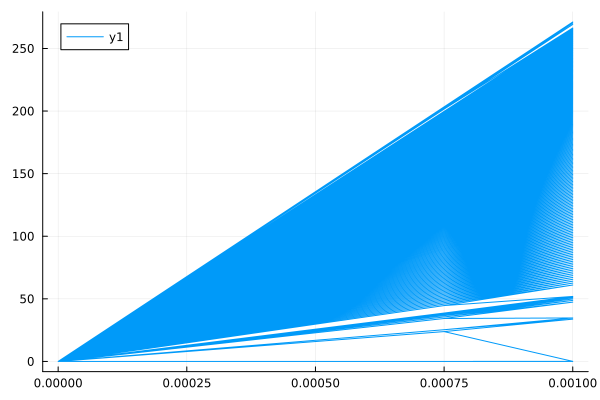

In [27]:
plot(Displacement,Load)

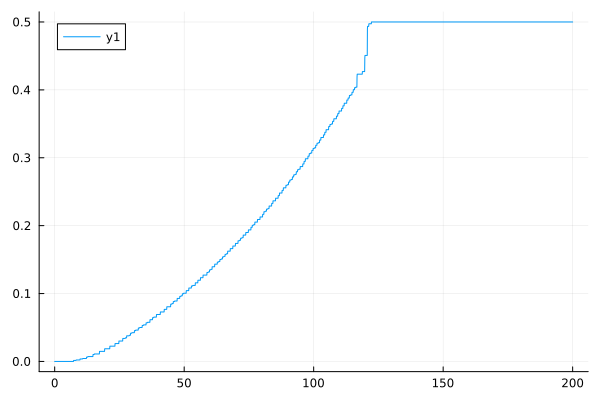

In [28]:
plot(NoofCycles[1:end],Xloccrack[1:end].-(0.5*L))

In [29]:
using DelimitedFiles
using CSV
using Plots

In [30]:
using LaTeXStrings

In [31]:
parent_path = "../PlottingFiles/"     # Go up one level and define the new folder name
mkpath(parent_path)

"../PlottingFiles"

In [32]:
cd("../PlottingFiles/")

In [33]:
NoofCyclesCSV = writedlm("kf05_Step16NoofCyclesPhlsfullVolDevNew$ls.csv",  NoofCycles, ',')
FracEnergyCSV = writedlm("kf05_Step16FracEnergyPhlsfullVolDevNew$ls.csv",  FracEnergy, ',')
LoadEnergyCSV = writedlm("kf05_Step16LoadPhlsfullVolDevNew$ls.csv",  Load, ',')

In [38]:
XloccrackCSV = writedlm("kf05_Step16XloccrackPhlsfullVolDevNew$ls.csv",  Xloccrack, ',')

In [37]:
FdegradCSV = writedlm("kf05_Step16FdegradPhlsfullVolDevNew$ls.csv",  αDegrad, ',')
αEnergyCSV = writedlm("kf05_Step16AlphaEnergyPhlsfullVolDevNew$ls.csv",  αEnergy, ',')